Physics Informed Neural Networks to approximate solutions of PDES

In [38]:
import matplotlib.pyplot as pyplot
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from Common import NeuralNet

torch.manual_seed(128)

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# assumes your NeuralNet class exists as you showed earlier

class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # extrema of the domain: (t, x) ∈ [0, 0.1] × [-1, 1]
        self.domain_extrema = torch.tensor([[0.0, 0.1],
                                            [-1.0, 1.0]])

        self.space_dimensions = 1
        self.lambda_u = 10.0

        # networks
        self.approximate_solution = NeuralNet(
            input_dimension=self.domain_extrema.shape[0],
            output_dimension=1,
            n_hidden_layers=4,
            neurons=20,
            regularization_param=0.0,
            regularization_exp=2.0,
            retrain_seed=42
        )

        self.approximate_coefficient = NeuralNet(
            input_dimension=self.domain_extrema.shape[0],
            output_dimension=1,
            n_hidden_layers=4,
            neurons=20,
            regularization_param=0.0,
            regularization_exp=2.0,
            retrain_seed=42
        )

        # Sobol sampler
        self.soboleng = torch.quasirandom.SobolEngine(
            dimension=self.domain_extrema.shape[0]
        )

        # training sets
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

        # sensors for measurements
        self.n_sensor = 50

    # map [0,1]^d -> [min,max]^d
    def convert(self, tens: torch.Tensor) -> torch.Tensor:
        assert tens.shape[1] == self.domain_extrema.shape[0]
        de = self.domain_extrema.to(tens.device, dtype=tens.dtype)
        return tens * (de[:, 1] - de[:, 0]) + de[:, 0]

    # u0(x) = -sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # exact solution u_t = (k=1) u_xx with the IC (here your “reference”)
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]
        u = -torch.exp(-np.pi**2 * t) * torch.sin(np.pi * x)
        return u

    def exact_conductivity(self, inputs):
        # spatially varying k(x) used for source term construction
        x = inputs[:, 1]
        k = (torch.sin(np.pi * x) + 1.1)
        return k

    def source(self, inputs):
        # s = -π^2 u * (1 - k(x))
        return - (np.pi**2) * self.exact_solution(inputs) * (1.0 - self.exact_conductivity(inputs))

    # temporal boundary (t = 0): u(0,x) = u0(x)
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full_like(input_tb[:, 0], t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)
        return input_tb, output_tb

    # spatial boundaries (x = x0 and x = xL): u(t,x0)=0, u(t,xL)=0
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full_like(input_sb_0[:, 1], x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full_like(input_sb_L[:, 1], xL)  


        output_sb_0 = torch.zeros((input_sb_0.shape[0], 1), dtype=input_sb_0.dtype, device=input_sb_0.device)
        output_sb_L = torch.zeros((input_sb_L.shape[0], 1), dtype=input_sb_L.dtype, device=input_sb_L.device)

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    # interior points for PDE residual
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1), dtype=input_int.dtype, device=input_int.device)
        return input_int, output_int

    # synthetic noisy measurements
    def get_measurement_data(self):
        torch.random.manual_seed(42)
        t = torch.linspace(0, float(self.domain_extrema[0, 1]), 25)
        x = torch.linspace(float(self.domain_extrema[1, 0]), float(self.domain_extrema[1, 1]), self.n_sensor)
        input_meas = torch.cartesian_prod(t, x)
        output_meas = self.exact_solution(input_meas).reshape(-1, 1)
        noise = 0.01 * torch.rand_like(output_meas)
        output_meas = output_meas + noise
        return input_meas, output_meas

    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()
        input_tb, output_tb = self.add_temporal_boundary_points()
        input_int, output_int = self.add_interior_points()

        training_set_sb = DataLoader(TensorDataset(input_sb, output_sb),
                                     batch_size=2 * self.space_dimensions * self.n_sb,
                                     shuffle=False)
        training_set_tb = DataLoader(TensorDataset(input_tb, output_tb),
                                     batch_size=self.n_tb,
                                     shuffle=False)
        training_set_int = DataLoader(TensorDataset(input_int, output_int),
                                      batch_size=self.n_int,
                                      shuffle=False)
        return training_set_sb, training_set_tb, training_set_int

    # boundary helpers
    def apply_initial_condition(self, input_tb):
        return self.approximate_solution(input_tb)

    def apply_boundary_conditions(self, input_sb):
        return self.approximate_solution(input_sb)

    # PDE residual: u_t - k(x,t) u_xx - s(t,x) = 0
    def compute_pde_residual(self, input_int):
        input_int = input_int.clone().detach().requires_grad_(True)

        u = self.approximate_solution(input_int).reshape(-1,)
        k = self.approximate_coefficient(input_int).reshape(-1,)

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        u_t = grad_u[:, 0]
        u_x = grad_u[:, 1]
        u_xx = torch.autograd.grad(u_x.sum(), input_int, create_graph=True)[0][:, 1]

        s = self.source(input_int).reshape(-1,)  

        residual = u_t - k * u_xx - s
        return residual.reshape(-1,)

    def compute_loss(self, inp_train_sb, u_train_sb,
                     inp_train_tb, u_train_tb,
                     inp_train_int, u_train_int,
                     verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        inp_meas, u_meas = self.get_measurement_data()
        u_pred_meas = self.approximate_solution(inp_meas)

        assert u_pred_sb.shape[1] == u_train_sb.shape[1]
        assert u_pred_tb.shape[1] == u_train_tb.shape[1]
        assert u_pred_meas.shape[1] == u_meas.shape[1]

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_meas - u_pred_meas

        loss_sb = torch.mean(r_sb.abs()**2)
        loss_tb = torch.mean(r_tb.abs()**2)
        loss_int = torch.mean(r_int.abs()**2)
        loss_meas = torch.mean(r_meas.abs()**2)

        loss_u = loss_sb + loss_tb + loss_meas
        loss = torch.log10(self.lambda_u * loss_u + loss_int)

        if verbose:
            print(
                "Total Loss:",
                round(loss.item(), 4),
                "| PDE Loss:",
                round(torch.log10(loss_int).item(), 4),
                "| Function Loss:",
                round(torch.log10(loss_u).item(), 4) 
            )

        return loss

    def fit(self, num_epochs, optimizer, verbose=True):
        history = []

        use_lbfgs = isinstance(optimizer, torch.optim.LBFGS)

        for epoch in range(num_epochs):
            if verbose:
                print("##########", epoch, "##########")

            for (inp_train_sb, u_train_sb), \
                (inp_train_tb, u_train_tb), \
                (inp_train_int, u_train_int) in zip(self.training_set_sb,
                                                    self.training_set_tb,
                                                    self.training_set_int):

                if use_lbfgs:
                    def closure():
                        optimizer.zero_grad(set_to_none=True)
                        loss = self.compute_loss(inp_train_sb, u_train_sb,
                                                 inp_train_tb, u_train_tb,
                                                 inp_train_int, u_train_int,
                                                 verbose=verbose)
                        loss.backward()
                        return loss
                    loss_val = optimizer.step(closure).item()
                    history.append(loss_val)
                else:
                    optimizer.zero_grad(set_to_none=True)
                    loss = self.compute_loss(inp_train_sb, u_train_sb,
                                             inp_train_tb, u_train_tb,
                                             inp_train_int, u_train_int,
                                             verbose=verbose)
                    loss.backward()
                    optimizer.step()
                    history.append(loss.item())

        print("Final Loss: ", history[-1])
        return history

    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        with torch.no_grad():
            output = self.approximate_solution(inputs).reshape(-1,)
            exact_output = self.exact_solution(inputs).reshape(-1,)

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].cpu(), inputs[:, 0].cpu(),
                             c=exact_output.cpu(), cmap="jet")
        axs[0].set_xlabel("x"); axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0]); axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].cpu(), inputs[:, 0].cpu(),
                             c=output.cpu(), cmap="jet")
        axs[1].set_xlabel("x"); axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1]); axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution"); axs[1].set_title("Approximate Solution")

        err_u = (torch.mean((output - exact_output)**2) /
                 torch.mean(exact_output**2)).sqrt() * 100
        print("L2 Relative Error Norm U: ", err_u.item(), "%")

        with torch.no_grad():
            approximate_conductivity = self.approximate_coefficient(inputs).reshape(-1,)
            exact_conductivity = self.exact_conductivity(inputs).reshape(-1,)

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].cpu(), inputs[:, 0].cpu(),
                             c=exact_conductivity.cpu(), cmap="jet")
        axs[0].set_xlabel("x"); axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0]); axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].cpu(), inputs[:, 0].cpu(),
                             c=approximate_conductivity.cpu(), cmap="jet")
        axs[1].set_xlabel("x"); axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1]); axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Conductivity"); axs[1].set_title("Approximate Conductivity")

        err_k = (torch.mean((approximate_conductivity - exact_conductivity)**2) /
                 torch.mean(exact_conductivity**2)).sqrt() * 100
        print("L2 Relative Error Norm K: ", err_k.item(), "%")
        plt.show()


In [40]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

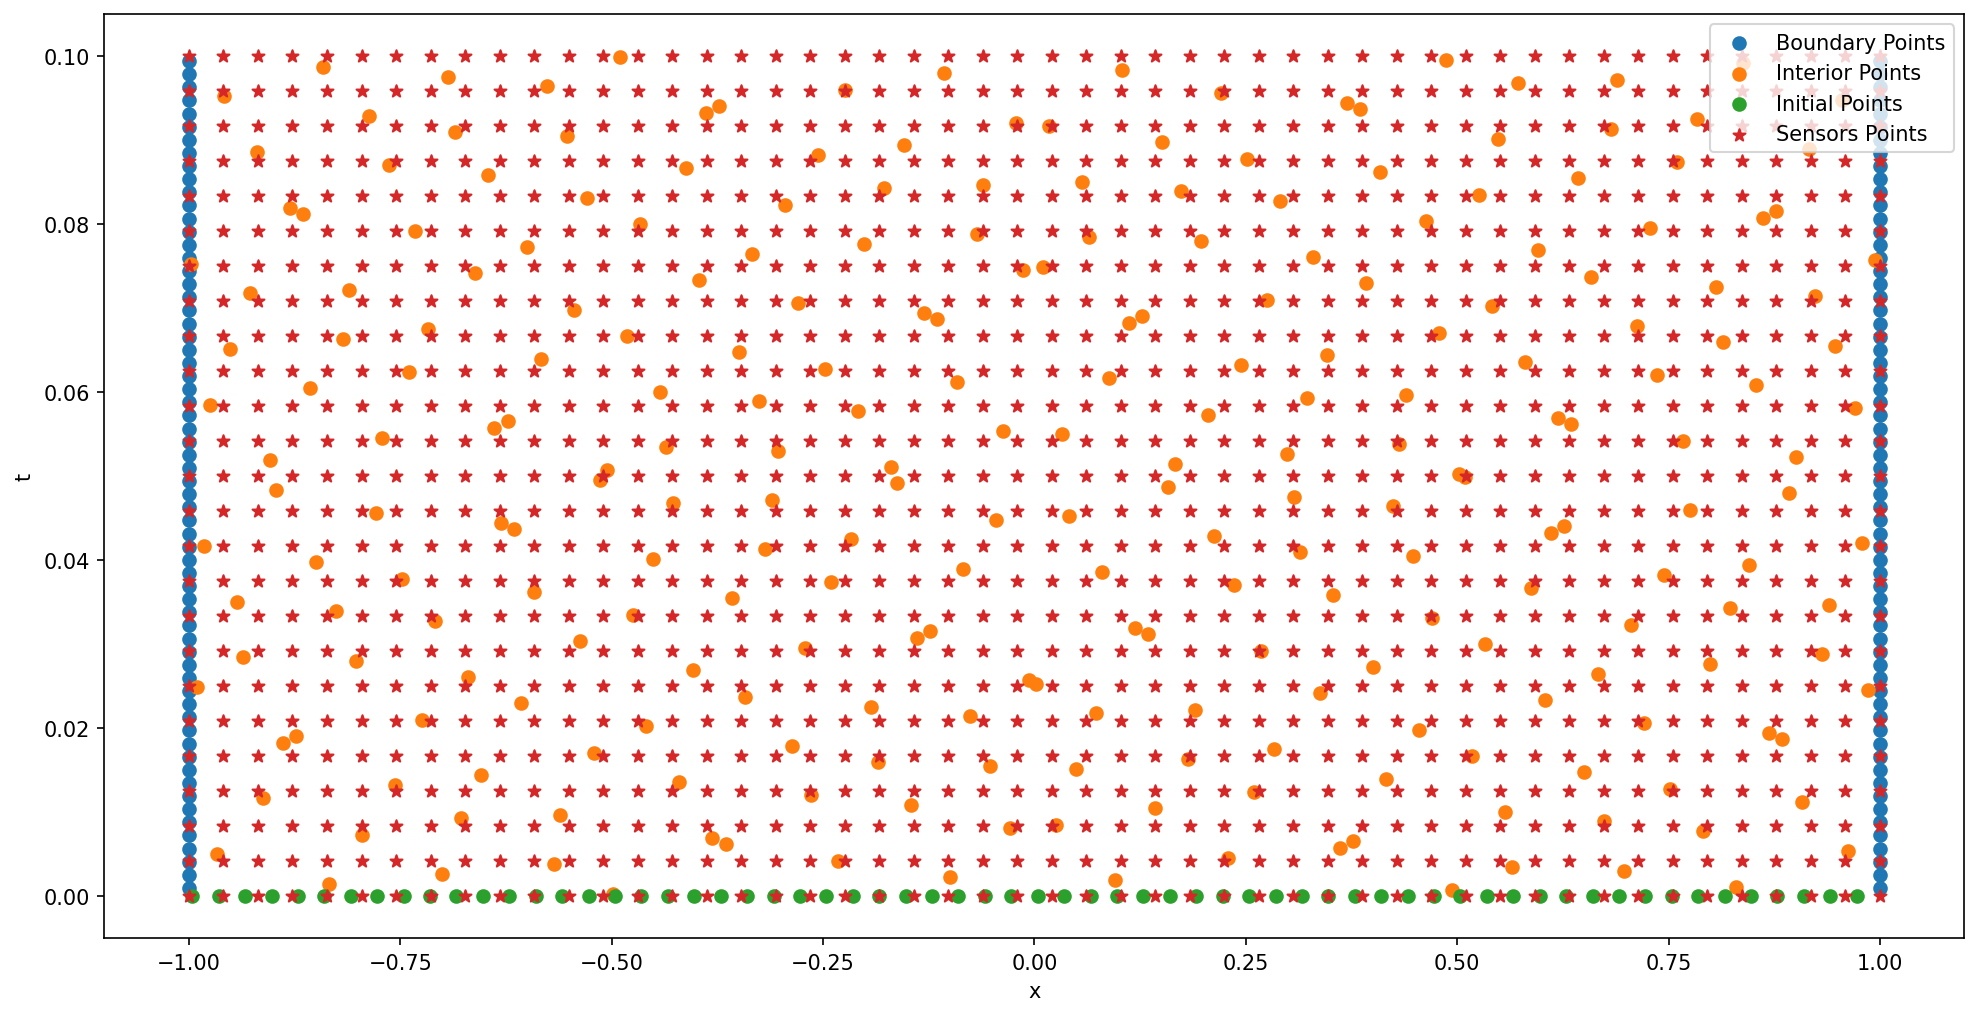

In [41]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_, output_meas_ = pinn.get_measurement_data()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_meas_[:, 1].detach().numpy(), input_meas_[:, 0].detach().numpy(), label="Sensors Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [42]:
n_epochs = 10
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.5),
                              max_iter=1000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

########## 0 ##########
Total Loss: 1.9526 | PDE Loss: 1.8761 | Function Loss: 0.1611
Total Loss: 1.906 | PDE Loss: 1.8384 | Function Loss: 0.0644
Total Loss: 1.5209 | PDE Loss: 1.3632 | Function Loss: 0.0044
Total Loss: 1.6578 | PDE Loss: 0.7413 | Function Loss: 0.6017
Total Loss: 1.4439 | PDE Loss: 1.0566 | Function Loss: 0.2148
Total Loss: 1.3281 | PDE Loss: 0.905 | Function Loss: 0.1222
Total Loss: 1.0766 | PDE Loss: 0.7614 | Function Loss: -0.2107
Total Loss: 0.9577 | PDE Loss: 0.6281 | Function Loss: -0.3165
Total Loss: 0.9077 | PDE Loss: 0.567 | Function Loss: -0.3569
Total Loss: 0.872 | PDE Loss: 0.512 | Function Loss: -0.3771
Total Loss: 0.8575 | PDE Loss: 0.4939 | Function Loss: -0.3888
Total Loss: 0.8441 | PDE Loss: 0.4779 | Function Loss: -0.4003
Total Loss: 0.8086 | PDE Loss: 0.4433 | Function Loss: -0.4364
Total Loss: 0.7227 | PDE Loss: 0.4116 | Function Loss: -0.5684
Total Loss: 0.6472 | PDE Loss: 0.3429 | Function Loss: -0.6507
Total Loss: 0.5535 | PDE Loss: 0.2414 | Fu

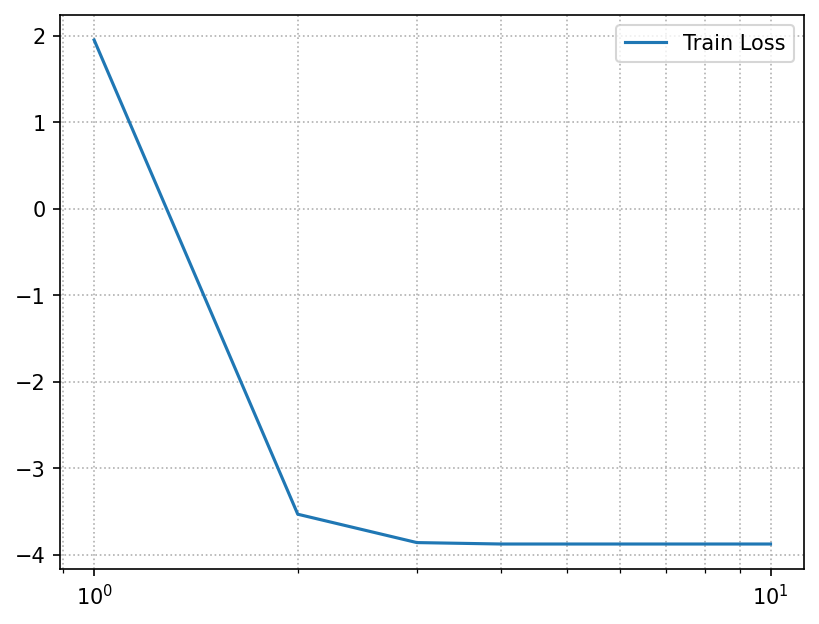

In [43]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

L2 Relative Error Norm U:  0.936061680316925 %
L2 Relative Error Norm K:  4.3425164222717285 %


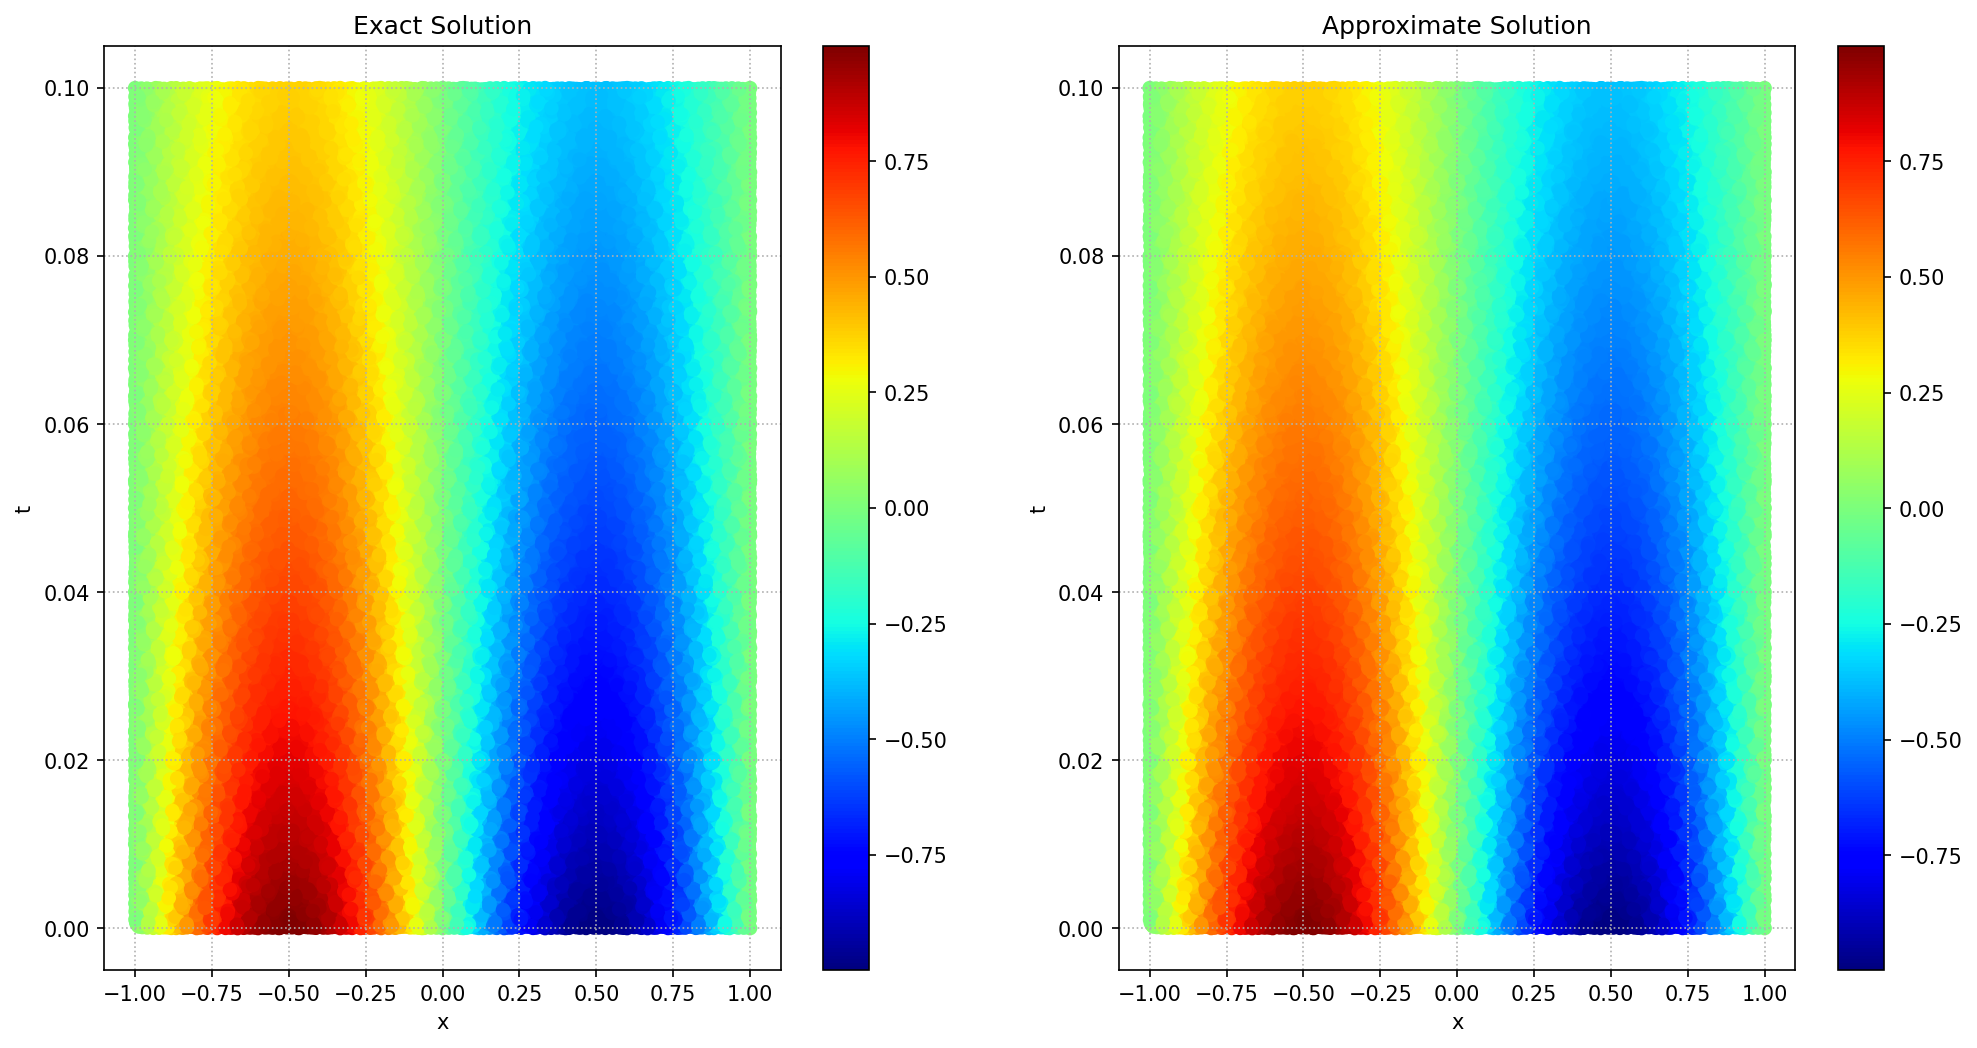

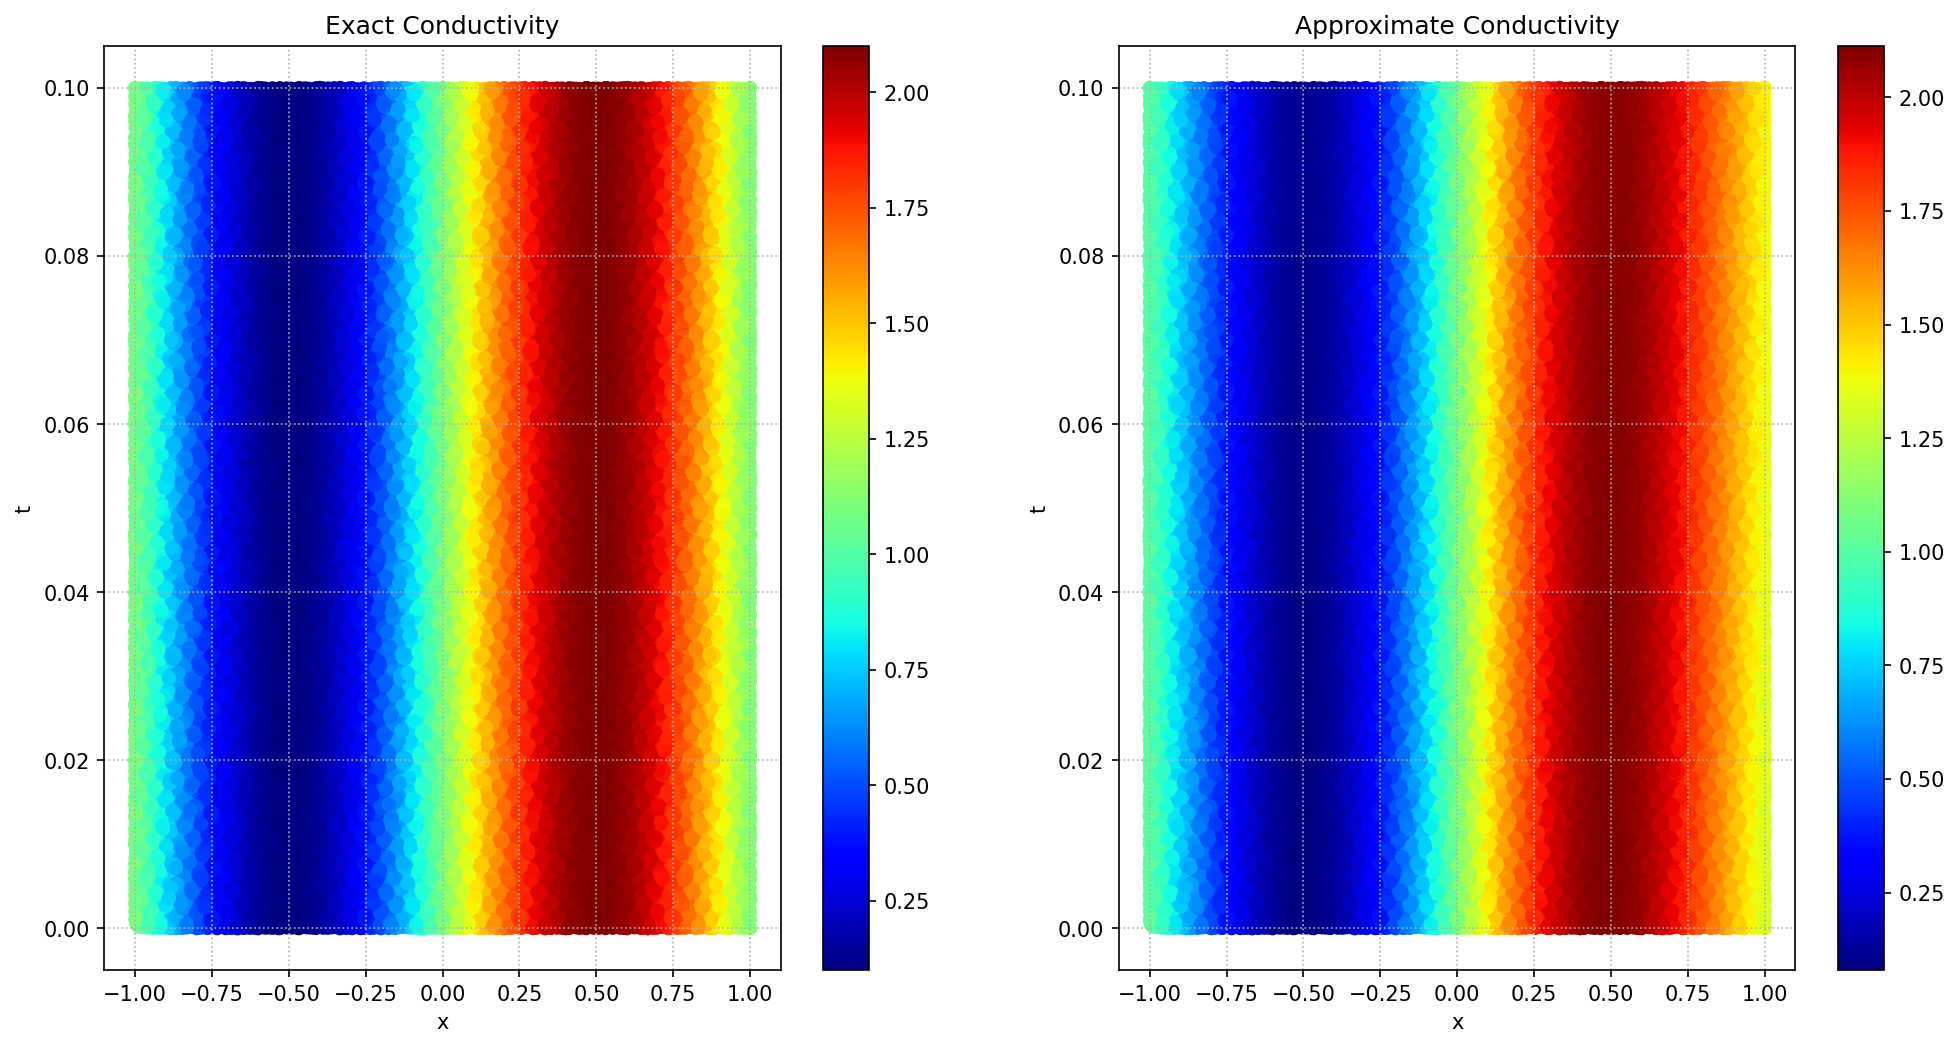

In [44]:
pinn.plotting()
